# Tracking a synchro transmitter using an Extended Kalman Filter

Copyright (C) 2022 Richard Hacker

License: CC BY+SA 4.0

Source on [GitLab](https://gitlab.com/lerichi/applied-process-control-and-simulation/-/blob/main/synchro-kalman-observer.ipynb)

This article can also be viewed on 
   * [nbviewer.org](https://nbviewer.org/urls/gitlab.com/lerichi/applied-process-control-and-simulation/-/raw/main/synchro-kalman-observer.ipynb)
   * [GitLab Pages](https://lerichi.gitlab.io/applied-process-control-and-simulation/synchro-kalman-observer.html)

# Introduction

A synchro transmitter is an extremely robust electromechanical transducer capable of measuring angles to a high degree of accuracy in adverse environmental conditions.

Essentially a synchro is a variable coupled AC transformer in the shape of a three phase synchronous electric motor or generator, the primary winding on the rotor and three phase secondary, poles positioned 120 degrees apart, on the stator. The primary is excited by a known high frequency alternating current. As the rotor angle changes, the magnetic coupling to the secondary poles change and as a result the amplitude of the secondary phase voltage. By measuring and comparing the phase amplitudes relative to each other, the rotor angle can be determined.

A resolver is very similar similar device also used to measure angles. However it is a two phase electric motor with 90 degrees between the secondary stator poles compared to the 120 degrees of a three phase synchro. Other devices in this family are linear and rotary variable differential transformers (LVDT/RVDT).

In this article we will be developing a Kalman filter as a type II tracking observer, having zero position error even when the rotor is spinning at constant speed. This is an interesting application for a Kalman filter since the Extended Kalman Filter is required due to the non-linear nature of the describing equations. We will also be confronted with state disturbance and measurement noise covariance matrices having non-zero off-diagonal elements.

Here is a list of online literature regarding synchro and resolvers:
* [AN252](http://www.analog.com/media/en/technical-documentation/application-notes/50205505838923AN252.pdf), Analog Devices
* [Synchro Application Guide](https://www.moog.com/content/dam/moog/literature/MCG/SynchroApplGuide.pdf), Moog Inc.
* [Synchro and Resolver Engineering Handbook](https://cb.wunderkis.de/wk-pub/resolver/synchrohandbook.pdf]), Moog Inc. section 2.1.1
* [Synchro/Resolver Conversion Handbook](https://www.ddc-web.com/Documents/synhdbk.pdf), DDC Inc. (Note that in Figure 1.11a $V_{3-2}$ is incorrect! It should be $V_{2-3}$)


# Theory of operation

Below is a picture of the physical construction, logical schematic representation and lastly a phase vector diagram of the output,



The primary on the rotor is excited with an alternating current typically in a frequency range between 400Hz to 10kHz. This is done either using slip rings or brushlesss via another transformer with the secondary on the rotor allowing it to rotate freely.

Usually the centre of the Y-connected secondary is not available. Thus only the phase-to-phase secondary voltage can be measured. The relation of these phase voltages to the excitation $V_E$ and rotor angle $\theta$ are:

$$
\begin{align*}
V_E &= V_{E0}\,\sin (\omega t + \phi)\\
V_{31} & = S_3 - S_1 = A\,V_E\,\sin\theta\\
V_{23} & = S_2 - S_3 = A\,V_E\,\sin\left(\theta + 2\,\pi\big/3\right)
    = A\,V_E\big/2\,\left(-\sin\theta + \sqrt{3}\cos\theta \right)\\
V_{12} & = S_1 - S_2 = A\,V_E\,\sin\left(\theta + 4\,\pi\big/3\right)
    = A\,V_E\big/2\,\left(-\sin\theta - \sqrt{3}\cos\theta \right)\\
\end{align*}
$$

Without further fuss, here is the output of a synchro transmitter.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from contextlib import contextmanager, nullcontext
plt.rcParams['figure.figsize'] = [15, 7]

sqrt3 = np.sqrt(3.) # we need sqrt(3) a few times

# Some conversion factors
Ts = 10e-6
RPM = 2*np.pi*Ts/60
kHz = 2*np.pi*Ts*1000

omega_n = lambda n: 2.*np.pi/n

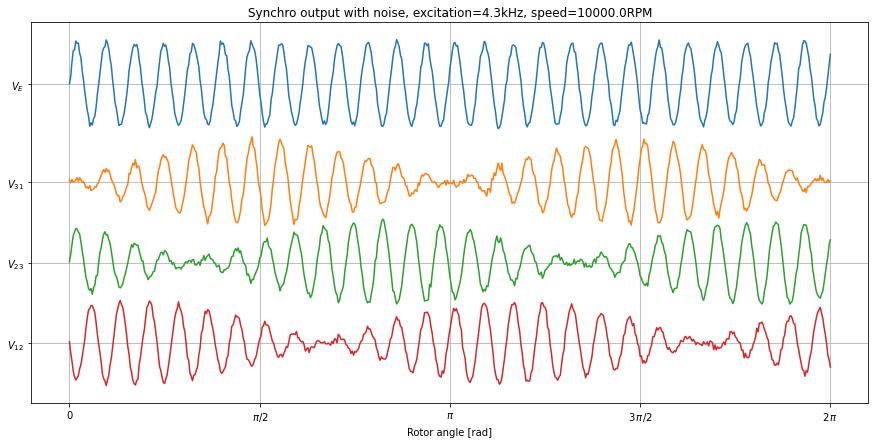

In [2]:
def synchro_output(exc=1., angle=[1.,0.]) -> np.array:
    """Calculate the secondary voltage given excitation and rotor angle"""
    c,s = angle[0:2]
    return exc/2.*np.array([2.*s, -s + sqrt3*c, -s - sqrt3*c])

def rotation(sin: float) -> np.array:
    cos = np.sqrt(1 - sin*sin)
    return np.array(((cos, -sin), (sin, cos)))

def oscillator(omega: float, init=[1.,0.]) -> np.array:
    """Endless generator for a [cos,sin] pair given a discrete frequency"""
    
    rot = rotation(omega)
    state = np.array(init)
    amplitude = np.linalg.norm(state)
    
    while True:
        
        # Adjust amplitude
        state *= amplitude/np.linalg.norm(state)
        
        omega = yield state
        if omega is not None:
            rot = rotation(omega)
            
        state = rot @ state # @ => matrix multiplication 
        
def synchro(omega_exc: float, omega_rotor: float,
            exc_init=np.array([0.,1.]), rotor_init=np.array([1.,0.]),
            measurement_noise=0.) -> np.array:
    """Simulate a synchro transmitter
    Returns: list(excitation, list(V31,V23,V12))
    """

    exc   = oscillator(omega_exc,   init=exc_init)
    rotor = oscillator(omega_rotor, init=rotor_init)

    while True:
        Ve = next(exc)[1]
        
        noise = np.random.standard_normal(4) * measurement_noise
        
        omega = yield (Ve + noise[0],
                       synchro_output(exc=Ve, angle=next(rotor)) + noise[1:])
        if omega is not None:
            rotor.send(omega)
        
with nullcontext():
    speed = 10000*RPM
    exc = 4.3*kHz
    
    n_samples = int(omega_n(speed))
    
    #s = synchro(omega_n(50), omega_n(n_samples), exc_init=[2.3,0], measurement_noise=0.1)
    s = synchro(exc, speed, exc_init=[2.3,0], measurement_noise=0.1)
    
    # Call the synchro for n_samples. Since the synchro returns a list
    # of excitation and phase voltages, stack them all together so
    # we get a matrix that we can  plot
    V = np.array([np.hstack(next(s)) for i in range(n_samples+1)])

    # Draw the graph
    y_spread = np.array([10,4.5,0,-4.5]) # used to spread out the matrix columns in the graph
    plt.plot(V + y_spread)
    plt.yticks(y_spread, [r'$V_E$',r'$V_{31}$',r'$V_{23}$',r'$V_{12}$'])
    plt.xticks(np.linspace(0,n_samples,5), ['0', '$\pi/2$','$\pi$','$3\,\pi/2$','$2\,\pi$'])
    plt.xlabel('Rotor angle [rad]')
    plt.title(f'Synchro output with noise, excitation={exc/kHz}kHz, speed={speed/RPM}RPM')
    plt.grid(True)


Clearly visible is how the line-to-line voltage oscillates in tune with excitation and how the amplitude slowly changes as the rotor's angle changes.

The regular zero crossings is also the reason why simple straight forward division by the excitation is not possible. Much better is to design a tracking observer which we will be looking at next.

# Design of a Kalman filter

Although a Kalman filter is essentially a recipy, there is quite a lot of work to do in preparing the filter input:

1. Define the state $\boldsymbol x$ and measurement vector $\boldsymbol y$
1. Derive the discrete state transition $F_k$ and output $H$ matrices
1. Estimate process $Q_k$ and measurement $R$ noise covariance matrices
1. Finally test the filter

## State space representation physical systems

The Kalman filter is based on the discrete-time state space representation of a process. It is one of the three mathematical models used to describe or model physical world systems.

The state space representation is centered around the concept of a state vector $\boldsymbol x_n$ that evolves over time as described in a state transition function $\boldsymbol f$. An output function $\boldsymbol h$ combines the states to an output vector $\boldsymbol y$. The state is disturbed by a vector $\boldsymbol w_n$ while the output is corrupted by measurement noise $\boldsymbol v$, both random variables of which only statistical properties are known. This is described by the following set of equations:

$$
\begin{align*}
\boldsymbol x_{n+1} &= \boldsymbol f(\boldsymbol x_n, \boldsymbol u_n) + \boldsymbol w_n && \textrm{State update equation} \\
\boldsymbol y_n &= \boldsymbol h(\boldsymbol x_n, \boldsymbol u_n) + \boldsymbol v_n && \textrm{Output equation}
\end{align*}
$$

Graphically it can be represented as

```
                       w_n                        v
                      |                          |
           +-----+    |               +-----+    |
   x_n     |     |    V               |     |    V
      +--->| f() |--->0----+--------->| h() |--->0---->
      |    |     |         |  x_n+1   |     |       y
      |    +-----+         |          +-----+
      |                    |
      |    +-----+         |
      |    |  -1 |         |
      +----| z   |<--------+
           |     |
           +-----+
```

where $z^{-1}$ is a unit time delay.

We will be exploring every part of this block diagram.


## State vector definition

The first most important step is to define the state vector. It has far reaching consequences for the entire filter, so much so as also having a direct effect on filter performance in case of non-linear systems.

In this system we can identify three states to track, together with a estimation of state variability:
- highly variable rotor angle $\alpha$,
- moderately constant rotor speed $\omega$ and
- essentially constant system gain $A$, only changing when a new transmittor is connected.

This suggests that the system has these three states and define the state vector to be $\boldsymbol x = [\alpha, \omega, A]^\textsf{T}$. This naïve approach has the following drawbacks:
* At every step we need to calculate sines of the rotor angle, an expensive function, three times. Even though computers are fast nowadays, it is always prudent to minimize the amount of effort required to solve a problem and thereby sometimes even improving response.
* More importantly, the angle $\alpha$ is the (discrete) integration of rotor speed $\omega$. This value is unbounded and calculating the sine of a very large angle is unprecise at best. You have to integrate carefully, keeping the angle in the range $\alpha \in [0, 2\,\pi\rangle$.

Another approach is to recognize that rotor angle and system gain can be combined into a single complex number. Rotor speed can be viewed as rotating this number by a small angle every sample step. Expressing the complex number using its real and imaginary components has the advantage that the cosine and sine is simply the real and imaginary components thereof. We will be exploring this strategy and define the state vector as:

$$
\boldsymbol x_n = \begin{bmatrix} c_n \\ s_n \\ \omega_n \end{bmatrix}
= \begin{bmatrix}A\,\cos\,n\,\omega_T \\ A\,\sin\,n\,\omega_T \\ \sin \omega_T \end{bmatrix}
$$

where:
* $n$ is the discrete sample step with sampling interval $T_s$
* $\omega_T$ is the discrete angular speed, related to real-time angular speed as $\omega_T = \omega\,T_s$
* $\omega_n = \sin\omega_T$ is the sine of discrete angular speed 
* $A$ is the system gain
* $(c_n, s_n)$ are the bounded real and imaginary parts of the complex number

Having defined the state vector we can continue deriving the state update function and matrix, the output or measurement matrix and state uncertainty and measurement noise covariance matrices.

## System state transition function and matrix

In this section we model the evolution of the state vector as a function of inputs and previous state: $\boldsymbol x_{n+1} = \boldsymbol f(\boldsymbol x_n, u_n)$. This is used during the prediction stage of the Kalman filter algorithm. 

This is quite easy, we just set $n \gets
n+1$ in the state equation above, expand using the [trignometric identity of sum of angles](https://en.wikipedia.org/wiki/List_of_trigonometric_identities#Angle_sum_and_difference_identities) and express the result in terms of the previous state:

$$
\begin{align*}
\boldsymbol x_{n+1}
= \boldsymbol f(\boldsymbol x_n)
& = \begin{bmatrix}
    A\,\cos\,(n + 1)\,\omega_T\\
    A\,\sin\,(n + 1)\,\omega_T\\
    \sin\omega_T
\end{bmatrix}\\
&= \begin{bmatrix}
    A\,\cos n\,\omega_T\,\cos \omega_T - A\,\sin n\,\omega_T\,\sin \omega_T\\
    A\,\sin n\,\omega_T\,\cos \omega_T + A\,\cos n\,\omega_T\,\sin \omega_T\\
    \sin\omega_T
\end{bmatrix}\\
&= \begin{bmatrix}
    c_n\,\sqrt{1 - \omega_n^2} - s_n\,\omega_n\\
    s_n\,\sqrt{1 - \omega_n^2} + c_n\,\omega_n\\
    \omega_n
\end{bmatrix}\\
\end{align*}
$$

Now, since we were concerned about computational effort, the square root function itself can be approximated by

$$
\left.\sqrt{1 - x^2}\;\right|_{x\approx0} \approx 1 - x^2\big/2
$$

cutting off the Taylor expansion at the second term, we can further simplify the state update equation to

$$
\boldsymbol f(\boldsymbol x_n)
\approx \begin{bmatrix}
    c_n\left(1 - \omega_n^2\big/2\right) - s_n\,\,\omega_n\\
    s_n\left(1 - \omega_n^2\big/2\right) + c_n\,\,\omega_n\\
    \omega_n
\end{bmatrix}
$$

This state transition function above is non-linear _vector_ in its states. Although we will be using it in the state prediction due to its accuracy, the Kalman filter requires the state transition _matrix_ $F_k$, linearized about the current state.

In linear cases, the state transition matrix can easily be read from the equation. For non-linear cases such as this, we have to resort to using the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) as the state transition matrix, where the columns of the resulting matrix are the partial differential of the state transition function to every state:

$$
F_k(\boldsymbol x_n) = \frac{\partial \boldsymbol f}{\partial \boldsymbol x_n}
= \begin{bmatrix}
    \dfrac{\partial \boldsymbol f}{\partial c_n} \quad
    \dfrac{\partial \boldsymbol f}{\partial s_n} \quad
    \dfrac{\partial \boldsymbol f}{\partial \omega_n}
\end{bmatrix}
= \begin{bmatrix}
    1 - \omega_n^2\big/2 & -\omega_n & -s_n - c_n\,\omega_n\\
    \omega_n & 1 - \omega_n^2\big/2 & c_n - s_n\,\omega_n\\
    0 & 0 & 1
\end{bmatrix}
$$

Since $|\omega_n| \ll 1$ and this equation is only an approximation after all, we can further simplify by discarding numerically small terms:

$$
F_k(\boldsymbol x_n) \approx \begin{bmatrix}
    1 & -\omega_n & -s_n\\
    \omega_n & 1 & \ c_n\\
    0 & 0 & \ 1
\end{bmatrix}
$$

To interpret intention of $F_k$ correctly, note that is is used to express the _change_ of the predicted state given a change in the current state:

$$
\Delta \boldsymbol x_{n+1} \approx F_k(\boldsymbol x_n)\,\Delta\boldsymbol x_n
$$


## State disturbance covariance matrix

In this section we investigate how the disturbance vector $\boldsymbol w_n$ is propagated through to the states and express this as a discrete state disturbance covariance matrix

$$
Q_k \doteq \operatorname{E}\left[\boldsymbol w_n\,\boldsymbol w_n^\textsf{T}\right]
$$

where the function $\operatorname{E}[X]$ is the expected value of random variable $X$.

Note that disturbances directly affect the system states, they influence the state transition function.

Considering the system at hand, we can identify the following sources of state disturbance:
* amplitude: the complex nmber $(c_n, s_n)$ state is disturbed by a small fraction of its coordinates $\delta A\,(c_n, s_n)$ thereby changing its length, with $\delta A \sim \mathcal{N}\left(0, \sigma_A^2\right)$
* rotational angular velocity: the state is disturbed by a small value $\delta \omega \sim \mathcal{N}\left(0, \sigma_\omega^2\right)$.

This leads to the following discrete state disturbance vector:

$$
\boldsymbol w_n = \begin{bmatrix}c_n\,\delta A_n \\ s_n\,\delta A_n \\ \delta\omega_n\end{bmatrix}
$$

Model disturbance covariance matrix can thus be determined:

$$
Q_k = \mathrm E \left[ \boldsymbol w_n\,\boldsymbol w_n^\textsf{T}\right]
= \begin{bmatrix}
    c_n^2\,\sigma_A^2 & c_n\,s_n\,\sigma_A^2 & 0\\
    c_n\,s_n\,\sigma_A^2 & s_n^2\,\sigma_A^2 & 0\\
    0 & 0 & \sigma_\omega^2
\end{bmatrix}
$$

This is the first order approximation. Usually this is sufficient.

Notice that $\delta\omega_0$ only propagates in another step of the state transition function to $(c_{n+1}, s_{n+1})$. This is where the state transition matrix could be used to predict the time evolution of $\boldsymbol w$:

$$
\boldsymbol w_2 = F_k(\boldsymbol x_0)\,\boldsymbol w_0 + \boldsymbol w_1
= \begin{bmatrix}
    \delta A_0\,(c_0 - s_0\,\omega_0) - \delta\omega_0\,s_0 \\
    \delta A_0\,(s_0 + c_0\,\omega_0) + \delta\omega_0\,c_0 \\
    \delta\omega_0
\end{bmatrix} + \begin{bmatrix}
c_1\,\delta A_1 \\
s_1\,\delta A_1 \\
\delta \omega_1 \\
\end{bmatrix}
$$

and then calculate

$$
Q_{2k} = \mathrm E \left[ \boldsymbol w_2\,\boldsymbol w_2^\textsf{T}\right]
\approx 2\,Q_k
+ \sigma_\omega^2 \begin{bmatrix}s_n^2 & -c_n\,s_n & -s_n \\ -c_n\,s_n & c_n^2 & c_n \\ -s_n & c_n & 0 \end{bmatrix}
$$

We will not be using $Q_{2k}$. This is just an excercise to show how to calculate the second order disturbance covariance matrix.

## Model output function with measurement noise

The output or measurement vector is now a simple linear combination of the states:

$$
\begin{align*}
\boldsymbol y = \begin{bmatrix} V_{31} \\ V_{23} \\ V_{12} \end{bmatrix}
&= (V_E + \delta V_E)\,A\,\begin{bmatrix} \sin n\,\omega_T \\ \sin\left(n\,\omega_T + 2\,\pi\big/3\right) \\ \sin\left(n\,\omega_T + 4\,\pi\big/3\right)  \end{bmatrix}
+ \begin{bmatrix} \delta V_{31} \\ \delta V_{23} \\ \delta V_{12} \end{bmatrix}\\
&= \frac{V_E + \delta V_E}{2}\,\begin{bmatrix} 2\,s \\ -s + \sqrt{3}\,c \\ -s - \sqrt{3}\,c \end{bmatrix}
+ \begin{bmatrix} \delta V_{31} \\ \delta V_{23} \\ \delta V_{12} \end{bmatrix}\\
&= H\,\boldsymbol x + \boldsymbol v
\end{align*}
$$

where $V_E$ is the (measured) excitation and $\delta V_x$ is uncorrelated measurement noise, all collected in the noise vector $\boldsymbol v$.

The output matrix can simply be read off the above equation:

$$
H = \frac{V_E}{2}\,\begin{bmatrix} 0 & 2 & 0 \\ \sqrt{3} & -1 & 0 \\ -\sqrt{3} & -1 & 0 \end{bmatrix}
$$

## Measurement noise covariance matrix

Measurement noise is read from the above measurement vector:

$$
\boldsymbol v
= \frac{\delta V_E}{2}\,\begin{bmatrix} 2\,s \\ -s + \sqrt{3}\,c \\ -s - \sqrt{3}\,c \end{bmatrix}
+ \begin{bmatrix} \delta V_{31} \\ \delta V_{23} \\ \delta V_{12} \end{bmatrix}
$$

where the measurement noise for each of the four measurements is assumed Gaussian distributed with zero mean
$\delta V_x \sim \mathcal{N}\left(0, \sigma_V^2\right)$. The measurement noise ist also assumed to be uncorrelated.

The measurement noise covariance matrix is defined as

$$
R \doteq \textrm{E}\,[\boldsymbol v\,\boldsymbol v^\textsf{T} ]
$$

Recognizing that measurement autocovariance is $\mathrm E\left[V_x^2\right] = \sigma_V^2$ and crosscovariance is $\mathrm E\left[V_x\,V_y\right] = 0$ (since the measurements are uncorrelated), we get the measurement covariance matrix:

$$
R = \frac{\sigma_V^2}{4}\,\begin{bmatrix}
    4\,s^2 & 2\,s\,(-s + \sqrt{3}\,c) & 2\,s\,(-s - \sqrt{3}\,c)\\
    2\,s\,(-s + \sqrt{3}\,c) & (-s + \sqrt{3}\,c)^2 & (-s + \sqrt{3}\,c)(-s - \sqrt{3}\,c)\\
    2\,s\,(-s - \sqrt{3}\,c) & (-s + \sqrt{3}\,c)(-s - \sqrt{3}\,c) & (-s - \sqrt{3}\,c)^2
    \end{bmatrix}
    %
    + \sigma_V^2\,\begin{bmatrix}1 & 0 & 0\\ 0 & 1 & 0\\ 0 & 0 & 1\end{bmatrix}
$$

Notice that the first term is the covariance matrix of the first term of $\boldsymbol v$ and similarly for the second term.

# Implementation

Now that we have all the required components, we would like to see the Kalman filter in action.

In [3]:
def synchro_kf(x,P,z,Sa,Sw,Sm):
    ''' One step of Kalman filter
    Arguments
        x: state vector 3x1
        P: state covariance matrix 3x3
        z: measurement vector list(2): z[0]: Ve (excitation)
                                       z[1]: line-to-line voltage (V31, V12, V23)
        Sa: amplitude variance
        Sw: rotational speed variance
        Sm: measurement variance
        
    Returns:
       list(state vector, state covariance matrix)
    '''
    
    # State prediction
    s_omega = x[2]
    c_omega = 1 - s_omega**2/2
    x[0:2] = np.array([[c_omega, -s_omega], [s_omega, c_omega]])@x[0:2]
    
    c,s,w = x
    exc = z[0]

    # Output value after prediction
    v1 =   s
    v2 = (-s + sqrt3*c)/2.
    v3 = (-s - sqrt3*c)/2.
    zm = exc*np.array([v1, v2, v3])

    # State transition matrix
    Fk = np.array([
        [1., -s_omega, -s],
        [s_omega,  1.,  c],
        [0.,       0., 1.],
    ])
    
    # Disturbance covariance matrix
    Qk = np.array([
        [Sa*c*c, Sa*c*s,  0],
        [Sa*c*s, Sa*s*s,  0],
        [     0,      0, Sw],
    ])
    
    # Measurement noise matrix
    R = Sm*np.array([
        [v1**2 + 1., v1*v2, v1*v3],
        [v2*v1, v2**2 + 1., v2*v3],
        [v3*v1, v3*v2, v3**2 + 1.]
    ])
    
    # System output matrix
    H = exc/2.*np.array([
        [    0.,  2., 0.],
        [ sqrt3, -1., 0.],
        [-sqrt3, -1., 0.],
    ])

    # State covariance matrix update
    P = Fk@P@Fk.T + Qk
    
    # Measurement error
    y = z[1] - zm
    
    # Kalman gain
    S = H@P@H.T + R
    K = P@H.T@np.linalg.inv(S)
    
    # state update
    x += K@y
    P -= K@H@P
    
    return [x,P]


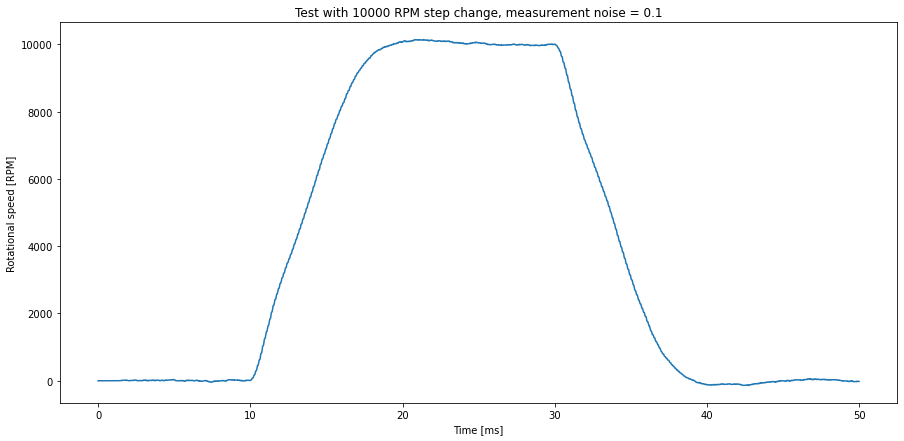

In [4]:
with nullcontext():
    
    # Here are the variances we will work with.
    # These are Kalman filter tuning parameters
    sigma_V = 0.001**2 # Measurement noise variance
    sigma_A = 0.001**2 # amplitude disturbance variance
    sigma_w = 3e-8**2 # omega disturbance variance; Use this to tune omega's response
    
    P = np.zeros((3,3))

    # Observer state vector, with incorrect rotational speed (third element)
    state = np.array([1., 0., 0.])
    
    measurement_noise = 0.1
    
    # Define a synchro to observe, rotor is stationary
    s = synchro(omega_exc=4.3*kHz, omega_rotor=0,
                exc_init=np.array((0., 1.5)), rotor_init=state[0:2],
                measurement_noise=measurement_noise)
    
    x0 = np.zeros((5000, 9)) # predefine a state history vector, to plot later
    for i in range(x0.shape[0]):
        # Take a measurement from synchro
        if i == 1000:
            s.send(1e4*RPM)
        if i == 3000:
            s.send(0.*RPM)
        z = next(s)
        
        # Call kalman filter
        state,P = synchro_kf(state, P, z, sigma_A, sigma_w, sigma_V)
        
        # Save state and covariance matrix in state history
        x0[i,:] = np.hstack((state, P.diagonal(), P.diagonal(1), P.diagonal(2)))
        
    plt.plot(np.arange(x0.shape[0])*Ts*1000, x0[:,2]/RPM)
    plt.ylabel(r'Rotational speed [RPM]')
    plt.xlabel('Time [ms]')
    plt.title(f'Test with 10000 RPM step change, measurement noise = {measurement_noise}')


# Conclusion

QED...

This impressively shows how well a properly designed Kalman filter works. This application is particularly challenging because because
* it is non-linear
* the disturbance cross correlation matrix $Q_k$ is not diagonal
* the measurement noise cross correlation $R$ is not diagonal

Nonetheless the result is certainly impressive.